In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import re
import pickle
import gc
import sys
import os
from collections import OrderedDict 


In [2]:
depressed_dataset = pd.read_csv("D:\Workspace\OVGU\SM_Depression\src\depTweetsOrderedByDateTimeWindowURLTokens.csv")

In [3]:
depressed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61972 entries, 0 to 61971
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   accountname       61972 non-null  object 
 1   description       61483 non-null  object 
 2   favorite_count    61937 non-null  float64
 3   location          51551 non-null  object 
 4   masked_user_id    61972 non-null  object 
 5   retweet_count     61968 non-null  object 
 6   timestamp         61972 non-null  object 
 7   tweets            61972 non-null  object 
 8   twittername       61972 non-null  object 
 9   user_type         61972 non-null  float64
 10  format            61972 non-null  int64  
 11  new_date          61972 non-null  object 
 12  time_window       61972 non-null  int64  
 13  tweets_url_token  61972 non-null  object 
 14  cleanData         61728 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [4]:
print(tf.__version__)

2.2.0


In [5]:
depressed_dataset.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData
0,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0.0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:00,@Twitter it's about time.\r\r\r\r\n\r\r\r\r\nL...,CmdrTinkerBell,1.0,1,2020-06-24 00:00,1,@Twitter it's about time.\r\r\r\r\n\r\r\r\r\nL...,it's about time. Lol IT'S NOT FAIR [URL] [URL]
1,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0.0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:02,"@w_terrence @PearlCathey8 Like deplorable, lik...",CmdrTinkerBell,1.0,1,2020-06-24 00:02,1,"@w_terrence @PearlCathey8 Like deplorable, lik...","Like deplorable, like donnie, have to use cont..."
2,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0.0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:05,@HarleyQuinnlif3 Dick always ruin things lol,CmdrTinkerBell,1.0,1,2020-06-24 00:05,1,@HarleyQuinnlif3 Dick always ruin things lol,Dick always ruin things lol
3,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,2.0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:13,After seeing pics of todays rally in Phoenix I...,CmdrTinkerBell,1.0,1,2020-06-24 00:13,1,After seeing pics of todays rally in Phoenix I...,After seeing pics of todays rally in Phoenix I...
4,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,2.0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:13,if I do get covid19 becuase I'm surrounded by ...,CmdrTinkerBell,1.0,1,2020-06-24 00:13,1,if I do get covid19 becuase I'm surrounded by ...,if I do get covid19 becuase I'm surrounded by ...


In [6]:
print(depressed_dataset.isnull().sum())


depressed_dataset = depressed_dataset.replace(np.nan, '', regex=True)

print(depressed_dataset.isnull().sum())
print("")
# print(depressed_dataset.info())

accountname             0
description           489
favorite_count         35
location            10421
masked_user_id          0
retweet_count           4
timestamp               0
tweets                  0
twittername             0
user_type               0
format                  0
new_date                0
time_window             0
tweets_url_token        0
cleanData             244
dtype: int64
accountname         0
description         0
favorite_count      0
location            0
masked_user_id      0
retweet_count       0
timestamp           0
tweets              0
twittername         0
user_type           0
format              0
new_date            0
time_window         0
tweets_url_token    0
cleanData           0
dtype: int64



In [7]:
tweet_text = depressed_dataset.loc[:,'cleanData']

In [8]:
tweet_text

0           it's about time. Lol IT'S NOT FAIR [URL] [URL]
1        Like deplorable, like donnie, have to use cont...
2                              Dick always ruin things lol
3        After seeing pics of todays rally in Phoenix I...
4        if I do get covid19 becuase I'm surrounded by ...
                               ...                        
61967    You need not to be afraid anymore. You are lov...
61968    I did register but I still didn't get the link...
61969               You have a beautiful name too! ð???â?�
61970                                                 yes!
61971                                 Can I get the link??
Name: cleanData, Length: 61972, dtype: object

In [9]:
def preprocessing(String): #default value is always true for stemming and stopwords
#     print(String)
#     print("")
    '''
    This function is used for preprocessing
    - Tokenization
    - Stemming
    - Stop Words
        
    '''
    
    influential_words = re.sub(r'[^a-zA-Z0-9_\[\]]', ' ', String)
#     print(influential_words)
#     tokens = nltk.word_tokenize(String)
#     print(tokens)
#     token = [word for word in tokens if word.isalpha()]
#     print(token)
#     influential_words = " ".join(token)
#     print(influential_words)
    influential_words = influential_words.lower()
#     print(influential_words)
#     influential_words = influential_words.split()
#     print(influential_words)
#     stemwords_string = " ".join(influential_words)
#     print(stemwords_string)
    return influential_words

In [10]:
final_text = []
for i in range(0,len(depressed_dataset.axes[0])):
    final_text.append(str(preprocessing(tweet_text[i])))

In [11]:
depressed_dataset['cleanData'] = final_text

In [12]:
del final_text,tweet_text,i

In [13]:
#clean special characters from cleanData row to apply BERT embeddings
def preprocess(tweets):
    tweets = tweets.replace("(<br/>)", "")
    tweets = tweets.replace('(<a).*(>).*(</a>)', '')
    tweets = tweets.replace('(&amp)', '')
    tweets = tweets.replace('(&gt)', '')
    tweets = tweets.replace('(&lt)', '')
    tweets = tweets.replace('(â€™)', '')
    tweets = tweets.replace('(\xa0)', ' ')
    tweets = tweets.replace('(https)', ' ')
    tweets = tweets.replace('(RT)', ' ')
    tweets = tweets.replace('(ðÿ)', '  ')
    tweets = tweets.replace('(\n)', '  ')
    return tweets

In [14]:
depressed_dataset['cleanData'] = depressed_dataset['cleanData'].apply(preprocess).astype(str)


In [15]:
depressed_dataset['encode_flag'] = 0

In [16]:
depressed_dataset['encode_flag'].value_counts()

0    61972
Name: encode_flag, dtype: int64

In [17]:
depressed_dataset.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag
0,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:00,@Twitter it's about time.\r\r\r\r\n\r\r\r\r\nL...,CmdrTinkerBell,1.0,1,2020-06-24 00:00,1,@Twitter it's about time.\r\r\r\r\n\r\r\r\r\nL...,it s about time lol it s not fair [url] [url],0
1,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:02,"@w_terrence @PearlCathey8 Like deplorable, lik...",CmdrTinkerBell,1.0,1,2020-06-24 00:02,1,"@w_terrence @PearlCathey8 Like deplorable, lik...",like deplorable like donnie have to use cont...,0
2,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:05,@HarleyQuinnlif3 Dick always ruin things lol,CmdrTinkerBell,1.0,1,2020-06-24 00:05,1,@HarleyQuinnlif3 Dick always ruin things lol,dick always ruin things lol,0
3,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,2,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:13,After seeing pics of todays rally in Phoenix I...,CmdrTinkerBell,1.0,1,2020-06-24 00:13,1,After seeing pics of todays rally in Phoenix I...,after seeing pics of todays rally in phoenix i...,0
4,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,2,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:13,if I do get covid19 becuase I'm surrounded by ...,CmdrTinkerBell,1.0,1,2020-06-24 00:13,1,if I do get covid19 becuase I'm surrounded by ...,if i do get covid19 becuase i m surrounded by ...,0


In [18]:
gc.collect()

40

In [19]:
depressed_dataset_1 = depressed_dataset[depressed_dataset.time_window == 1]
depressed_dataset_2 = depressed_dataset[depressed_dataset.time_window == 2]
depressed_dataset_3 = depressed_dataset[depressed_dataset.time_window == 3]
depressed_dataset_4 = depressed_dataset[depressed_dataset.time_window == 4]
depressed_dataset_5 = depressed_dataset[depressed_dataset.time_window == 5]
depressed_dataset_6 = depressed_dataset[depressed_dataset.time_window == 6]
depressed_dataset_7 = depressed_dataset[depressed_dataset.time_window == 7]
depressed_dataset_8 = depressed_dataset[depressed_dataset.time_window == 8]
depressed_dataset_9 = depressed_dataset[depressed_dataset.time_window == 9]
depressed_dataset_10 = depressed_dataset[depressed_dataset.time_window == 10]
depressed_dataset_11 = depressed_dataset[depressed_dataset.time_window == 11]
depressed_dataset_12 = depressed_dataset[depressed_dataset.time_window == 12]
depressed_dataset_13 = depressed_dataset[depressed_dataset.time_window == 13]
depressed_dataset_14 = depressed_dataset[depressed_dataset.time_window == 14]


for i in range(1,15):
    filename = "depressed_dataset_"+str(i)
    print(filename)
    print(getattr(sys.modules[__name__], f"depressed_dataset_{i}").shape)
    print("")

depressed_dataset_1
(700, 16)

depressed_dataset_2
(1093, 16)

depressed_dataset_3
(3223, 16)

depressed_dataset_4
(4868, 16)

depressed_dataset_5
(5463, 16)

depressed_dataset_6
(6878, 16)

depressed_dataset_7
(7786, 16)

depressed_dataset_8
(8278, 16)

depressed_dataset_9
(8394, 16)

depressed_dataset_10
(5696, 16)

depressed_dataset_11
(4408, 16)

depressed_dataset_12
(2729, 16)

depressed_dataset_13
(1569, 16)

depressed_dataset_14
(887, 16)



**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 1**

In [20]:


depressed_data_embedfile_1 = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_1_embedding.pkl","rb")

depressed_data_embed_1 = pickle.load(depressed_data_embedfile_1)

In [21]:
len(depressed_data_embed_1.keys())

684

In [22]:
depressed_data_embed_1 = OrderedDict(depressed_data_embed_1)

In [23]:
depressed_data_embed_1_flag = {key:int(1) for key, value in depressed_data_embed_1.items()}

In [24]:
len(depressed_data_embed_1_flag.keys())

684

In [25]:
depressed_dataset_1["encode_flag"] = depressed_dataset_1["cleanData"].apply(lambda x: depressed_data_embed_1_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
depressed_dataset_1.encode_flag.value_counts()

1    700
Name: encode_flag, dtype: int64

In [27]:
depressed_dataset_1.cleanData.nunique()

684

**Clustering on Time window 1 dataset**

**Approach 1 - kMeans**

In [28]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
len(list(depressed_data_embed_1.values()))

684

In [30]:
depressed_embeddings_1 = np.array(list(depressed_data_embed_1.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

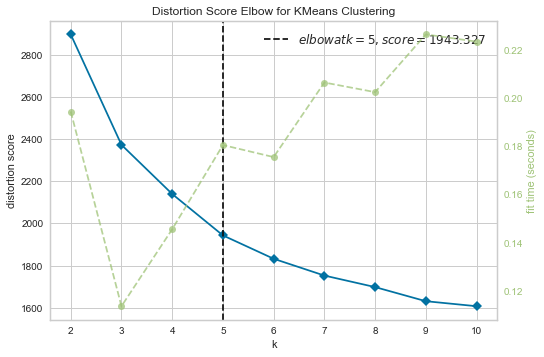

In [31]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings_1)    
visualizer.show()  

In [57]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings_1)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [58]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

684

In [59]:
from sklearn.metrics import silhouette_score


silhouette_score(depressed_embeddings_1, kmeans_labels)


0.3058028109907898

In [121]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embed_1.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [122]:
tweet_label_df.head()

,cleanData,cluster_label
0,it s about time lol it s not fair [url] [url],4
1,like deplorable like donnie have to use cont...,3
2,dick always ruin things lol,3
3,after seeing pics of todays rally in phoenix i...,4
4,if i do get covid19 becuase i m surrounded by ...,4


In [123]:
depressed_dataset_with_labels_1 = pd.merge(depressed_dataset_1, tweet_label_df, on='cleanData')

In [124]:
depressed_dataset_with_labels_1.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:00,@Twitter it's about time.\r\r\r\r\n\r\r\r\r\nL...,CmdrTinkerBell,1.0,1,2020-06-24 00:00,1,@Twitter it's about time.\r\r\r\r\n\r\r\r\r\nL...,it s about time lol it s not fair [url] [url],1,4
1,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:02,"@w_terrence @PearlCathey8 Like deplorable, lik...",CmdrTinkerBell,1.0,1,2020-06-24 00:02,1,"@w_terrence @PearlCathey8 Like deplorable, lik...",like deplorable like donnie have to use cont...,1,3
2,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:05,@HarleyQuinnlif3 Dick always ruin things lol,CmdrTinkerBell,1.0,1,2020-06-24 00:05,1,@HarleyQuinnlif3 Dick always ruin things lol,dick always ruin things lol,1,3
3,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,2,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:13,After seeing pics of todays rally in Phoenix I...,CmdrTinkerBell,1.0,1,2020-06-24 00:13,1,After seeing pics of todays rally in Phoenix I...,after seeing pics of todays rally in phoenix i...,1,4
4,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,2,Exploring the universe,depressed_user_11,0.0,24-06-2020 00:13,if I do get covid19 becuase I'm surrounded by ...,CmdrTinkerBell,1.0,1,2020-06-24 00:13,1,if I do get covid19 becuase I'm surrounded by ...,if i do get covid19 becuase i m surrounded by ...,1,4


In [126]:
depressed_dataset_with_labels_1.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [128]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [129]:
output_filename = "depTweets_window_1_kmeans_withLabel.csv"

In [131]:
depressed_dataset_with_labels_1.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [132]:
depressed_dataset_with_labels_1.cluster_label.value_counts()

3    377
4    151
0     89
1     63
2     20
Name: cluster_label, dtype: int64

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 2**

In [137]:


depressed_data_embedfile_2 = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_2_embedding.pkl","rb")

depressed_data_embedfile_2 = pickle.load(depressed_data_embedfile_2)

In [138]:
len(depressed_data_embedfile_2.keys())

1019

In [139]:
depressed_data_embedfile_2 = OrderedDict(depressed_data_embedfile_2)

In [144]:
depressed_data_embed_2_flag = {key:int(2) for key, value in depressed_data_embedfile_2.items()}

In [145]:
len(depressed_data_embed_2_flag.keys())

1019

In [146]:
depressed_dataset_2["encode_flag"] = depressed_dataset_2["cleanData"].apply(lambda x: depressed_data_embed_2_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [147]:
depressed_dataset_2.encode_flag.value_counts()

2    1093
Name: encode_flag, dtype: int64

In [148]:
depressed_dataset_2.cleanData.nunique()

1019

**Clustering on Time window 2 dataset**

**Approach 1 - kMeans**

In [149]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [150]:
len(list(depressed_data_embedfile_2.values()))

1019

In [151]:
depressed_embeddings_2 = np.array(list(depressed_data_embedfile_2.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

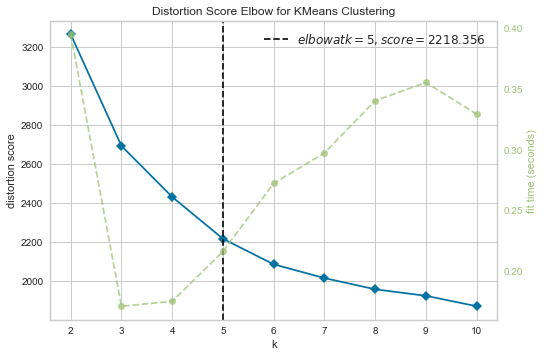

In [152]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings_2)    
visualizer.show()  

In [153]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings_2)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [154]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

1019

In [155]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile_2.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [156]:
tweet_label_df.head()

,cleanData,cluster_label
0,i love u bby and i fully support u i hope ur ...,2
1,that white man should be arrested all black l...,0
2,obviously how many times has trump declared ba...,1
3,so does this mean that you did in fact know ab...,2
4,chickennugget,0


In [157]:
depressed_dataset_with_labels_2 = pd.merge(depressed_dataset_2, tweet_label_df, on='cleanData')

In [158]:
depressed_dataset_with_labels_2.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,suki supremacy â˜�ï¸�âœ¨,space ghost // late nights in the middle of ju...,1,under the moon,depressed_user_81,0.0,01-07-2020 00:15,@hesrem i love u bby and i fully support u! i ...,sweetenersage,1.0,1,2020-07-01 00:15,2,@hesrem i love u bby and i fully support u! i ...,i love u bby and i fully support u i hope ur ...,2,2
1,Â©ï¸�denise dalphondÂ©ï¸�,anarchy is not violent. it is the absence of s...,0,"Ypsilanti, MI",depressed_user_14,0.0,01-07-2020 00:24,That white man should be arrested. All Black L...,Dalphond,1.0,1,2020-07-01 00:24,2,That white man should be arrested. All Black L...,that white man should be arrested all black l...,2,0
2,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,3,Exploring the universe,depressed_user_11,1.0,01-07-2020 01:38,@508gloryFelix Obviously how many times has Tr...,CmdrTinkerBell,1.0,1,2020-07-01 01:38,2,@508gloryFelix Obviously how many times has Tr...,obviously how many times has trump declared ba...,2,1
3,Cmdr. Nasty Tinkerbell of the 4077th,NSFW \r\r\r\r\nWoman \r\r\r\r\nDisabled \r\r\r...,0,Exploring the universe,depressed_user_11,0.0,01-07-2020 01:42,@BrianKarem @PressSec @realDonaldTrump So does...,CmdrTinkerBell,1.0,1,2020-07-01 01:42,2,@BrianKarem @PressSec @realDonaldTrump So does...,so does this mean that you did in fact know ab...,2,2
4,suki supremacy â˜�ï¸�âœ¨,space ghost // late nights in the middle of ju...,1,under the moon,depressed_user_81,0.0,01-07-2020 02:00,@hannah_ruthie CHICKENNUGGET,sweetenersage,1.0,1,2020-07-01 02:00,2,@hannah_ruthie CHICKENNUGGET,chickennugget,2,0


In [160]:
depressed_dataset_with_labels_2.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [161]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [163]:
output_filename = "depTweets_window_2_kmeans_withLabel.csv"

In [164]:
depressed_dataset_with_labels_2.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [165]:
depressed_dataset_with_labels_2.cluster_label.value_counts()

0    666
3    162
2    146
1     93
4     26
Name: cluster_label, dtype: int64

In [166]:
del depressed_data_embed_2_flag,depressed_data_embedfile_2,depressed_dataset_with_labels_2,depressed_embeddings_2

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 3**

In [167]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_3_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

In [168]:
len(depressed_data_embedfile.keys())

2977

In [169]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [170]:
depressed_data_embed_flag = {key:int(2) for key, value in depressed_data_embedfile.items()}

In [171]:
len(depressed_data_embed_flag.keys())

2977

In [172]:
len(depressed_dataset_3)

3223

In [173]:
depressed_dataset_3["encode_flag"] = depressed_dataset_3["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [174]:
depressed_dataset_3.encode_flag.value_counts()

2    3223
Name: encode_flag, dtype: int64

In [175]:
depressed_dataset_3.cleanData.nunique()

2977

**Clustering on Time window 3 dataset**

**Approach 1 - kMeans**

In [176]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [177]:
len(list(depressed_data_embedfile.values()))

2977

In [178]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

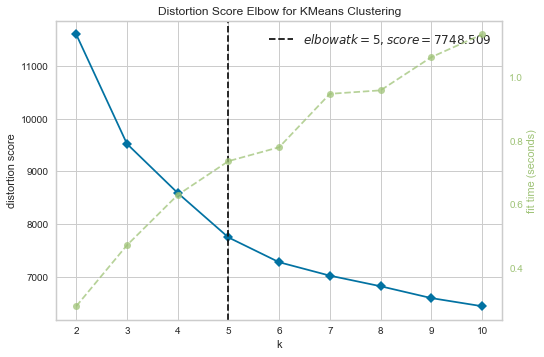

In [179]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [180]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [181]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

2977

In [182]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [183]:
tweet_label_df.head()

,cleanData,cluster_label
0,meh i m sad,1
1,idk if i m more triggered than i am jealous an...,1
2,please give me my relapse honeymoon phase back...,2
3,prayers for the family on this difficult day,2
4,tuna t sub it s been the same 20 for th...,3


In [184]:
tweet_label_df.cluster_label.value_counts()

3    1749
2     539
0     319
1     289
4      81
Name: cluster_label, dtype: int64

In [185]:
depressed_dataset_with_labels_3 = pd.merge(depressed_dataset_3, tweet_label_df, on='cleanData')

In [186]:
depressed_dataset_with_labels_3.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,1,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,7/8/2020 0:00,meh i'm sad,fluxkcals,1.0,2,2020-07-08 00:00,3,meh i'm sad,meh i m sad,2,1
1,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,5,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,7/8/2020 0:00,idk if i'm more triggered than i am jealous an...,fluxkcals,1.0,2,2020-07-08 00:00,3,idk if i'm more triggered than i am jealous an...,idk if i m more triggered than i am jealous an...,2,1
2,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,13,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,7/8/2020 0:02,please give me my relapse honeymoon phase back...,fluxkcals,1.0,2,2020-07-08 00:02,3,please give me my relapse honeymoon phase back...,please give me my relapse honeymoon phase back...,2,2
3,T,Wellness has never been so fun!,0,"Addison, TX",depressed_user_80,0.0,08-07-2020 00:05,@FOX4 Prayers for the family on this difficult...,studio8addison,1.0,1,2020-07-08 00:05,3,@FOX4 Prayers for the family on this difficult...,prayers for the family on this difficult day,2,2
4,jessaðŸ§ƒ,mentally ill,2,she/her 20,depressed_user_13,0.0,08-07-2020 00:05,TUNA T SUB ... itâ€™s been the same $20 for t...,constantnothing,1.0,1,2020-07-08 00:05,3,TUNA T SUB ... itâ€™s been the same $20 for t...,tuna t sub it s been the same 20 for th...,2,3


In [187]:
depressed_dataset_with_labels_3.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [188]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [189]:
output_filename = "depTweets_window_3_kmeans_withLabel.csv"

In [190]:
depressed_dataset_with_labels_3.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [191]:
depressed_dataset_with_labels_3.cluster_label.value_counts()

3    1992
2     541
0     319
1     290
4      81
Name: cluster_label, dtype: int64

In [192]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels_3,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 4**

In [193]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_4_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 4

In [194]:
len(depressed_data_embedfile.keys())

4442

In [195]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [196]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [197]:
len(depressed_data_embed_flag.keys())

4442

In [198]:
len(depressed_dataset_4)

4868

In [199]:
depressed_dataset_4["encode_flag"] = depressed_dataset_4["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [200]:
depressed_dataset_4.encode_flag.value_counts()

4    4868
Name: encode_flag, dtype: int64

In [201]:
depressed_dataset_4.cleanData.nunique()

4442

**Clustering on Time window 3 dataset**

**Approach 1 - kMeans**

In [202]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [203]:
len(list(depressed_data_embedfile.values()))

4442

In [204]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

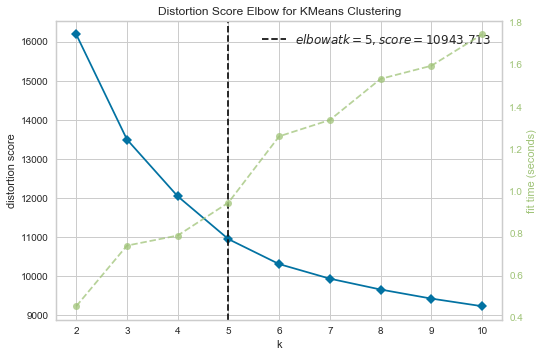

In [205]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [206]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [207]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

4442

In [208]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [209]:
tweet_label_df.head()

,cleanData,cluster_label
0,yes who knew [url],2
1,exactly and it s so frustrating because even ...,1
2,when men try to explain why you shouldn t ha...,0
3,some of y all are some fckn weirdos quit ...,0
4,i m ill not sick,2


In [210]:
tweet_label_df.cluster_label.value_counts()

2    2426
0     851
4     589
3     447
1     129
Name: cluster_label, dtype: int64

In [211]:
depressed_dataset_with_labels_4 = pd.merge(depressed_dataset_4, tweet_label_df, on='cleanData')

In [212]:
depressed_dataset_with_labels_4.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,Zanna Shirmana,Oh! Hi! I'm a HIP (hearing-impaired person) wh...,1,United States,depressed_user_99,0.0,7/15/2020 0:00,@kathryninman9 Yes. Who knew?\r\r\r\n\r\r\r\nh...,ZannaShirmana,1.0,2,2020-07-15 00:00,4,@kathryninman9 Yes. Who knew?\r\r\r\n\r\r\r\n[...,yes who knew [url],4,2
1,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,1,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,7/15/2020 0:00,@limbsfall exactly. and it's so frustrating be...,fluxkcals,1.0,2,2020-07-15 00:00,4,@limbsfall exactly. and it's so frustrating be...,exactly and it s so frustrating because even ...,4,1
2,Kaia â˜€ï¸�,Black Lives Matter,1,I travel too much for this,depressed_user_39,0.0,7/15/2020 0:01,When men try to explain why you shouldnâ€™t ha...,KaiaVictoria,1.0,2,2020-07-15 00:01,4,When men try to explain why you shouldnâ€™t ha...,when men try to explain why you shouldn t ha...,4,0
3,ð�??ð�??ð�?¡ ê?¥,ð�??ð�?? ð�?? ð�??ð�??ð�??ð�?? ð�??ð�??ð�??ð�?...,18,,depressed_user_45,0.0,7/15/2020 0:02,Some of yâ??all are some fckn weirdos... QUIT ...,lexaabadie,1.0,2,2020-07-15 00:02,4,Some of yâ??all are some fckn weirdos... QUIT ...,some of y all are some fckn weirdos quit ...,4,0
4,Â©ï¸�denise dalphondÂ©ï¸�,anarchy is not violent. it is the absence of s...,1,"Ypsilanti, MI",depressed_user_14,0.0,15-07-2020 00:10,"@YoungMoneySite @LilTunechi Iâ€™m ill, not sick.",Dalphond,1.0,1,2020-07-15 00:10,4,"@YoungMoneySite @LilTunechi Iâ€™m ill, not sick.",i m ill not sick,4,2


In [213]:
depressed_dataset_with_labels_4.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [214]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [215]:
output_filename = "depTweets_window_4_kmeans_withLabel.csv"

In [216]:
depressed_dataset_with_labels_4.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [217]:
depressed_dataset_with_labels_4.cluster_label.value_counts()

2    2812
0     855
4     623
3     448
1     130
Name: cluster_label, dtype: int64

In [218]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels_4,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 5**

In [219]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_5_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 5

In [220]:
len(depressed_data_embedfile.keys())

5060

In [221]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [222]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [223]:
len(depressed_data_embed_flag.keys())

5060

In [224]:
len(depressed_dataset_5)

5463

In [225]:
depressed_dataset_5["encode_flag"] = depressed_dataset_5["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [226]:
depressed_dataset_5.encode_flag.value_counts()

5    5463
Name: encode_flag, dtype: int64

In [227]:
depressed_dataset_5.cleanData.nunique()

5060

**Clustering on Time window 5 dataset**

**Approach 1 - kMeans**

In [228]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [229]:
len(list(depressed_data_embedfile.values()))

5060

In [230]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

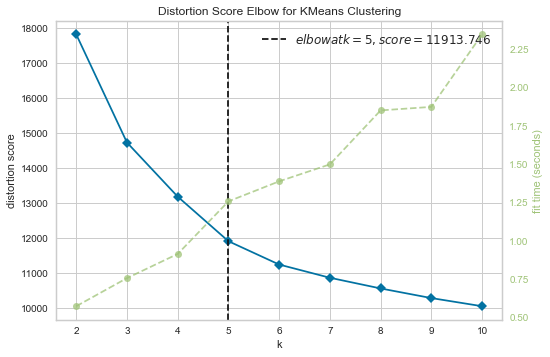

In [231]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [232]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [233]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

5060

In [234]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [235]:
tweet_label_df.head()

,cleanData,cluster_label
0,what are you getting i only have 1 and can ...,0
1,guys i just wanna know what you all follow my ...,1
2,oh wow that s recent hope you continue to h...,1
3,what would y all do [url],1
4,aren t we all,1


In [236]:
tweet_label_df.cluster_label.value_counts()

1    2973
0     960
2     583
4     443
3     101
Name: cluster_label, dtype: int64

In [237]:
depressed_dataset_with_labels_5 = pd.merge(depressed_dataset_5, tweet_label_df, on='cleanData')

In [238]:
depressed_dataset_with_labels_5.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,Maybe the Mayans were right... 2021 wya?,"30. 1st Gen ðŸŽ“ Grad. Survivor, surviving, wi...",0,Dallas Metro - Tejas,depressed_user_9,0.0,7/22/2020 0:06,@MelloRello3 What are you getting? I only have...,cajuntexan214,1.0,2,2020-07-22 00:06,5,@MelloRello3 What are you getting? I only have...,what are you getting i only have 1 and can ...,5,0
1,??pap?lrux??,18 yrs || Female || ???? || Huge Furry ll Mas...,2,,depressed_user_28,0.0,7/22/2020 0:12,Guys I just wanna know what you all follow my ...,heavymetalpapi,1.0,2,2020-07-22 00:12,5,Guys I just wanna know what you all follow my ...,guys i just wanna know what you all follow my ...,5,1
2,Maybe the Mayans were right... 2021 wya?,"30. 1st Gen ðŸŽ“ Grad. Survivor, surviving, wi...",1,Dallas Metro - Tejas,depressed_user_9,0.0,7/22/2020 0:16,@SamarB14 @AbrahamAlexnder @keonmonte Oh wow t...,cajuntexan214,1.0,2,2020-07-22 00:16,5,@SamarB14 @AbrahamAlexnder @keonmonte Oh wow t...,oh wow that s recent hope you continue to h...,5,1
3,Maybe the Mayans were right... 2021 wya?,"30. 1st Gen ðŸŽ“ Grad. Survivor, surviving, wi...",0,Dallas Metro - Tejas,depressed_user_9,0.0,7/22/2020 0:17,What would yâ€™all do? https://t.co/4PNtSa3oun,cajuntexan214,1.0,2,2020-07-22 00:17,5,What would yâ€™all do? [URL],what would y all do [url],5,1
4,Goblin HB is eating pie.,Connor | 19 | Indigenous Latine | Queer Transm...,0,Any Pronouns ??Fem Pronouns??,depressed_user_27,0,7/22/2020 0:19,@MikkytheHamster Aren't we all?,goblin_screech,1.0,2,2020-07-22 00:19,5,@MikkytheHamster Aren't we all?,aren t we all,5,1


In [239]:
depressed_dataset_with_labels_5.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [240]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [241]:
output_filename = "depTweets_window_5_kmeans_withLabel.csv"

In [242]:
depressed_dataset_with_labels_5.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [243]:
depressed_dataset_with_labels_5.cluster_label.value_counts()

1    3344
0     963
2     612
4     443
3     101
Name: cluster_label, dtype: int64

In [244]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels_5,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 6**

In [245]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_6_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 6

In [246]:
len(depressed_data_embedfile.keys())

6382

In [247]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [248]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [249]:
len(depressed_data_embed_flag.keys())

6382

In [250]:
len(depressed_dataset_6)

6878

In [251]:
depressed_dataset_6["encode_flag"] = depressed_dataset_6["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [252]:
depressed_dataset_6.encode_flag.value_counts()

6    6878
Name: encode_flag, dtype: int64

In [253]:
depressed_dataset_6.cleanData.nunique()

6382

**Clustering on Time window 6 dataset**

**Approach 1 - kMeans**

In [254]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [255]:
len(list(depressed_data_embedfile.values()))

6382

In [256]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

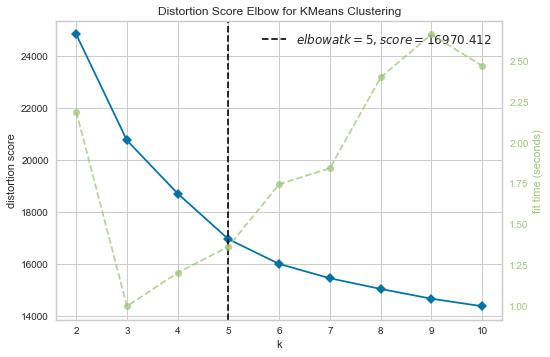

In [257]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [258]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [259]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

6382

In [260]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [261]:
tweet_label_df.head()

,cleanData,cluster_label
0,uh huh 100,0
1,huh [url],0
2,[url],0
3,wtf it s a medication i ve been on for over a ...,4
4,thank you gorgeous,0


In [262]:
tweet_label_df.cluster_label.value_counts()

0    3249
1    1311
3     841
4     745
2     236
Name: cluster_label, dtype: int64

In [263]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_6, tweet_label_df, on='cleanData')

In [264]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,Lucie Luce x Luce,She/her! âš§ 29 | pan | polyam | 18+ only | cu...,2,"Pennsylvania, USA",depressed_user_47,0.0,7/29/2020 0:01,@CatgirlFingies Uh-huh! 100%,LuceXLuceWest,1.0,2,2020-07-29 00:01,6,@CatgirlFingies Uh-huh! 100%,uh huh 100,6,0
1,ð�??ð�??ð�?¡ ê?¥,ð�??ð�?? ð�?? ð�??ð�??ð�??ð�?? ð�??ð�??ð�??ð�?...,593,,depressed_user_45,17.0,7/29/2020 0:02,Huh?? https://t.co/47YlM3ZXhu,lexaabadie,1.0,2,2020-07-29 00:02,6,Huh?? [URL],huh [url],6,0
2,Dr. J-Cat...5150ðŸ’€ðŸŒ¹,An open mind. Aspiring for greater knowledge f...,1,your mindðŸ¤”,depressed_user_36,0.0,7/29/2020 0:03,@minasofia5 https://t.co/C8JAUl1vOq,jcat_5150,1.0,2,2020-07-29 00:03,6,@minasofia5 [URL],[url],6,0
3,Dr. J-Cat...5150ðŸ’€ðŸŒ¹,An open mind. Aspiring for greater knowledge f...,2,your mindðŸ¤”,depressed_user_36,0.0,7/29/2020 0:29,@CatBrothers6 https://t.co/3Ow0GgOS4m,jcat_5150,1.0,2,2020-07-29 00:29,6,@CatBrothers6 [URL],[url],6,0
4,foldedð???,Dead by Daylight affiliated streamer â?¡ Most ...,1,,depressed_user_95,0.0,7/29/2020 0:31,@TUR_Pathing @tur_complex https://t.co/9AqdpQ33o2,xofolded,1.0,2,2020-07-29 00:31,6,@TUR_Pathing @tur_complex [URL],[url],6,0


In [265]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [266]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [267]:
output_filename = "depTweets_window_6_kmeans_withLabel.csv"

In [268]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [269]:
depressed_dataset_with_labels.cluster_label.value_counts()

0    3716
1    1316
3     864
4     746
2     236
Name: cluster_label, dtype: int64

In [270]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 7**

In [271]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_7_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 7

In [272]:
len(depressed_data_embedfile.keys())

7254

In [273]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [274]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [275]:
len(depressed_data_embed_flag.keys())

7254

In [276]:
len(depressed_dataset_7)

7786

In [277]:
depressed_dataset_7["encode_flag"] = depressed_dataset_7["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [278]:
depressed_dataset_7.encode_flag.value_counts()

7    7786
Name: encode_flag, dtype: int64

In [279]:
depressed_dataset_7.cleanData.nunique()

7254

**Clustering on Time window 7 dataset**

**Approach 1 - kMeans**

In [280]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [281]:
len(list(depressed_data_embedfile.values()))

7254

In [282]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

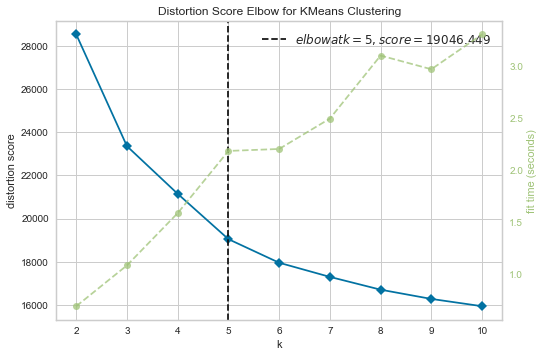

In [283]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [284]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [285]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

7254

In [286]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [287]:
tweet_label_df.head()

,cleanData,cluster_label
0,reminds me of the thing that s like the chan...,3
1,2020 the year everything turned out to be cak...,3
2,i hate seeing fma twit be like roy its just a...,4
3,one of the few things i m grateful for about...,0
4,water and natural fruit juices are superior bu...,2


In [288]:
tweet_label_df.cluster_label.value_counts()

2    4017
3    1421
0     962
4     657
1     197
Name: cluster_label, dtype: int64

In [289]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_7, tweet_label_df, on='cleanData')

In [290]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,Ruby,rubyâ??s back... back again... 24 with a math ...,0,,depressed_user_72,0.0,8/5/2020 0:01,@stephtxt reminds me of the thing thatâ??s lik...,rubysback,1.0,2,2020-08-05 00:01,7,@stephtxt reminds me of the thing thatâ??s lik...,reminds me of the thing that s like the chan...,7,3
1,ipickuppennies,"Disability, frugality and other life adventure...",3,"Phoenix, AZ",depressed_user_32,0.0,8/5/2020 0:02,2020: The year everything turned out to be cak...,ipickuppennies,1.0,2,2020-08-05 00:02,7,2020: The year everything turned out to be cak...,2020 the year everything turned out to be cak...,7,3
2,â�¤ kinnie â�¤,Dylan | a3 and hypmic | ð?�­ð???ð??² | ACAB | ...,0,(he/fae) nsfw (rarely),depressed_user_60,0.0,8/5/2020 0:03,"i hate seeing fma twit be like ""roy its just a...",nintendowiimote,1.0,2,2020-08-05 00:03,7,"i hate seeing fma twit be like ""roy its just a...",i hate seeing fma twit be like roy its just a...,7,4
3,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,4,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,8/5/2020 0:04,one of the few things iâ€™m grateful for about...,fluxkcals,1.0,2,2020-08-05 00:04,7,one of the few things iâ€™m grateful for about...,one of the few things i m grateful for about...,7,0
4,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,2,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,8/5/2020 0:05,water and natural fruit juices are superior bu...,fluxkcals,1.0,2,2020-08-05 00:05,7,water and natural fruit juices are superior bu...,water and natural fruit juices are superior bu...,7,2


In [291]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [292]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [293]:
output_filename = "depTweets_window_7_kmeans_withLabel.csv"

In [294]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [295]:
depressed_dataset_with_labels.cluster_label.value_counts()

2    4525
3    1424
0     979
4     661
1     197
Name: cluster_label, dtype: int64

In [296]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 8**

In [297]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_8_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 8

In [298]:
len(depressed_data_embedfile.keys())

7701

In [299]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [300]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [301]:
len(depressed_data_embed_flag.keys())

7701

In [302]:
len(depressed_dataset_8)

8278

In [303]:
depressed_dataset_8["encode_flag"] = depressed_dataset_8["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [304]:
depressed_dataset_8.encode_flag.value_counts()

8    8278
Name: encode_flag, dtype: int64

In [305]:
depressed_dataset_8.cleanData.nunique()

7701

**Clustering on Time window 8 dataset**

**Approach 1 - kMeans**

In [306]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [307]:
len(list(depressed_data_embedfile.values()))

7701

In [308]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

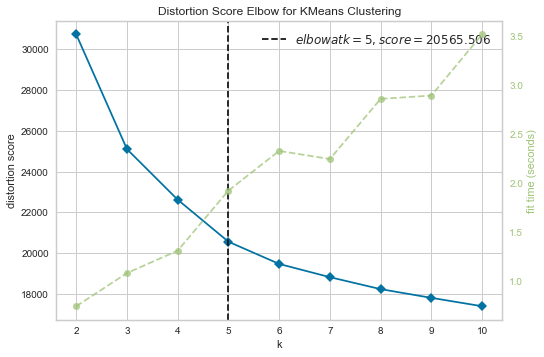

In [309]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [310]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [311]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

7701

In [312]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [313]:
tweet_label_df.head()

,cleanData,cluster_label
0,he does but we keep him mostly clipped lol he ...,2
1,period sis that s energy,2
2,and what area of the country so you live in i...,0
3,with all these bizarre events occuring togethe...,2
4,when people women nb gfs included because an...,2


In [314]:
tweet_label_df.cluster_label.value_counts()

2    4131
3    1510
0    1050
1     761
4     249
Name: cluster_label, dtype: int64

In [315]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_8, tweet_label_df, on='cleanData')

In [316]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,â?¨ â?¢Â·Ì«â?¢ prÎ¹nceÑ?Ñ? peacÐ½ Ï?Ï?Ï? ð??¿,25. Cannabis Microbiologist . Casual Streamer....,1,"New York, USA",depressed_user_46,0.0,8/12/2020 0:00,@Trunks420910 He does but we keep him mostly c...,lextaliones_,1.0,2,2020-08-12 00:00,8,@Trunks420910 He does but we keep him mostly c...,he does but we keep him mostly clipped lol he ...,8,2
1,ala anasaiaðŸ¦‹,saia like say-a lotðŸ™ˆ| the â€œ+â€� in lbgtq+...,1,"new mexico, usa",depressed_user_6,0.0,08-12-2020 00:03,"@MarielaBaca6 period sis, thatâ€™s ENERGY",anasaia7,1.0,1,2020-08-12 00:03,8,"@MarielaBaca6 period sis, thatâ€™s ENERGY",period sis that s energy,8,2
2,ipickuppennies,"Disability, frugality and other life adventure...",1,"Phoenix, AZ",depressed_user_32,0.0,8/12/2020 0:04,@SuperBocchi @CoachJoeHart And what area of th...,ipickuppennies,1.0,2,2020-08-12 00:04,8,@SuperBocchi @CoachJoeHart And what area of th...,and what area of the country so you live in i...,8,0
3,PIXIE??GYARU??,"??THEY/SHE??MINORS, DNI??SOUL SUCKIN' FAIRY??A...",2,??CASH APP ?? $PIXIEGYARU ??,depressed_user_65,0.0,08-12-2020 00:04,With all these bizarre events occuring togethe...,pixiegyaru,1.0,1,2020-08-12 00:04,8,With all these bizarre events occuring togethe...,with all these bizarre events occuring togethe...,8,2
4,ala anasaiaðŸ¦‹,saia like say-a lotðŸ™ˆ| the â€œ+â€� in lbgtq+...,2,"new mexico, usa",depressed_user_6,0.0,08-12-2020 00:05,@MarielaBaca6 @ogcamie @allexx_r_ when people(...,anasaia7,1.0,1,2020-08-12 00:05,8,@MarielaBaca6 @ogcamie @allexx_r_ when people(...,when people women nb gfs included because an...,8,2


In [317]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [318]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [319]:
output_filename = "depTweets_window_8_kmeans_withLabel.csv"

In [320]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [321]:
depressed_dataset_with_labels.cluster_label.value_counts()

2    4675
3    1513
0    1078
1     763
4     249
Name: cluster_label, dtype: int64

In [322]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 9**

In [323]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_9_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 9

In [324]:
len(depressed_data_embedfile.keys())

7675

In [325]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [326]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [327]:
len(depressed_data_embed_flag.keys())

7675

In [328]:
len(depressed_dataset_9)

8394

In [329]:
depressed_dataset_9["encode_flag"] = depressed_dataset_9["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [330]:
depressed_dataset_9.encode_flag.value_counts()

9    8394
Name: encode_flag, dtype: int64

In [331]:
depressed_dataset_9.cleanData.nunique()

7675

**Clustering on Time window 9 dataset**

**Approach 1 - kMeans**

In [332]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [333]:
len(list(depressed_data_embedfile.values()))

7675

In [334]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

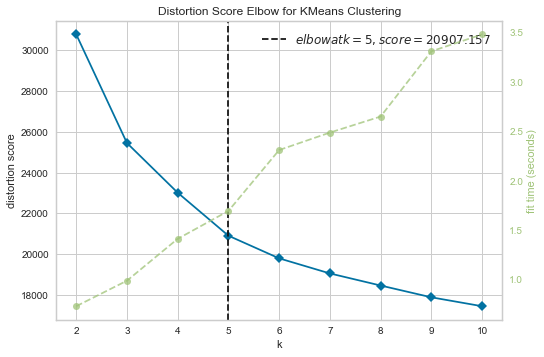

In [335]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [336]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [337]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

7675

In [338]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [339]:
tweet_label_df.head()

,cleanData,cluster_label
0,713 burned already you know what i m happy...,0
1,healing and rediscovering myself,1
2,that s so cute,1
3,i don t believe it either lmao,1
4,,1


In [340]:
tweet_label_df.cluster_label.value_counts()

1    4134
0    1441
4    1124
3     765
2     211
Name: cluster_label, dtype: int64

In [341]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_9, tweet_label_df, on='cleanData')

In [342]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,daisy.,ð�˜�ð�˜„: ð�—²ð�—± ð�˜�ð�˜„ð�˜� ð�—¿ð�—®ð�—»ð�...,1,23 ã€¡ she/her ã€¡ eng/spa,depressed_user_24,0.0,8/19/2020 0:10,"713 burned already? you know what, iâ€™m happy...",fluxkcals,1.0,2,2020-08-19 00:10,9,"713 burned already? you know what, iâ€™m happy...",713 burned already you know what i m happy...,9,0
1,DeeJay,Live Like Tomorrow Your Last ð??¤ |NJ| ð??µð??...,0,,depressed_user_94,0.0,8/19/2020 0:11,healing and rediscovering myself .,xFuckYaTweetsx,1.0,2,2020-08-19 00:11,9,healing and rediscovering myself .,healing and rediscovering myself,9,1
2,the giant garf that makes all of da rulez,"Spencer, he/him, 23, paranormal and horror ent...",1,"vancouver, bc",depressed_user_85,0,8/19/2020 0:12,@michaeIIangdon that's so cute!!!,tinygremlins,1.0,2,2020-08-19 00:12,9,@michaeIIangdon that's so cute!!!,that s so cute,9,1
3,Jaz,21. ...,1,,depressed_user_34,0.0,8/19/2020 0:13,@AlexisLeannXoXo I donâ??t believe it either lmao,Jaazz23,1.0,2,2020-08-19 00:13,9,@AlexisLeannXoXo I donâ??t believe it either lmao,i don t believe it either lmao,9,1
4,Eddie Danrith??B L M,eddie/danny??he/him??bard??just a huge dork th...,1,,depressed_user_82,0.0,8/19/2020 0:13,@TheOtherMxSella ??????,tadpolecowboy,1.0,2,2020-08-19 00:13,9,@TheOtherMxSella ??????,,9,1


In [343]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [344]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [345]:
output_filename = "depTweets_window_9_kmeans_withLabel.csv"

In [346]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [347]:
depressed_dataset_with_labels.cluster_label.value_counts()

1    4815
0    1452
4    1151
3     765
2     211
Name: cluster_label, dtype: int64

In [348]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 10**

In [349]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_10_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 10

In [350]:
len(depressed_data_embedfile.keys())

5266

In [351]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [352]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [353]:
len(depressed_data_embed_flag.keys())

5266

In [354]:
len(depressed_dataset_10)

5696

In [355]:
depressed_dataset_10["encode_flag"] = depressed_dataset_10["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [356]:
depressed_dataset_10.encode_flag.value_counts()

10    5696
Name: encode_flag, dtype: int64

In [357]:
depressed_dataset_10.cleanData.nunique()

5266

**Clustering on Time window 10 dataset**

**Approach 1 - kMeans**

In [358]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [359]:
len(list(depressed_data_embedfile.values()))

5266

In [360]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

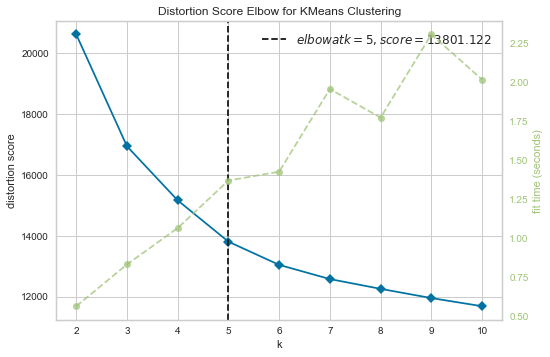

In [361]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [362]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [363]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

5266

In [364]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [365]:
tweet_label_df.head()

,cleanData,cluster_label
0,me,3
1,sorry things are so hard right now i m glad...,0
2,enunciation is a killer,3
3,i think i m finally working through the wave o...,0
4,oh that would ve been a good counteroffer,3


In [366]:
tweet_label_df.cluster_label.value_counts()

3    2833
1    1025
0     758
4     481
2     169
Name: cluster_label, dtype: int64

In [367]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_10, tweet_label_df, on='cleanData')

In [368]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,foldedð???,Dead by Daylight affiliated streamer â?¡ Most ...,1,,depressed_user_95,0.0,8/26/2020 0:01,@PapiQuentin_ Me ð?¥º,xofolded,1.0,2,2020-08-26 00:01,10,@PapiQuentin_ Me ð?¥º,me,10,3
1,ipickuppennies,"Disability, frugality and other life adventure...",2,"Phoenix, AZ",depressed_user_32,0.0,8/26/2020 0:04,@amandadashpage Sorry things are so hard right...,ipickuppennies,1.0,2,2020-08-26 00:04,10,@amandadashpage Sorry things are so hard right...,sorry things are so hard right now i m glad...,10,0
2,Zero (they/their),Autistic. ADHD. NB. \r\r\r\nExtra. Compulsivel...,1,,depressed_user_100,0.0,8/26/2020 0:10,@DEITY_OF_CRINGE Enunciation is a killer.,ZeroWrites,1.0,2,2020-08-26 00:10,10,@DEITY_OF_CRINGE Enunciation is a killer.,enunciation is a killer,10,3
3,"Jason Custer, PhD",Rhet/Comp PhD from @fsu_englishdept // Academi...,77,Here and There Along the Echo,depressed_user_35,0.0,8/26/2020 0:11,I think I'm finally working through the wave o...,JasonCusterPhD,1.0,2,2020-08-26 00:11,10,I think I'm finally working through the wave o...,i think i m finally working through the wave o...,10,0
4,ipickuppennies,"Disability, frugality and other life adventure...",2,"Phoenix, AZ",depressed_user_32,0.0,8/26/2020 0:12,@dollarrev Oh that wouldâ€™ve been a good coun...,ipickuppennies,1.0,2,2020-08-26 00:12,10,@dollarrev Oh that wouldâ€™ve been a good coun...,oh that would ve been a good counteroffer,10,3


In [369]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [370]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [371]:
output_filename = "depTweets_window_10_kmeans_withLabel.csv"

In [372]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [373]:
depressed_dataset_with_labels.cluster_label.value_counts()

3    3219
1    1027
0     799
4     482
2     169
Name: cluster_label, dtype: int64

In [374]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 11**

In [375]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_11_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 11

In [376]:
len(depressed_data_embedfile.keys())

4125

In [377]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [378]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [379]:
len(depressed_data_embed_flag.keys())

4125

In [380]:
len(depressed_dataset_11)

4408

In [381]:
depressed_dataset_11["encode_flag"] = depressed_dataset_11["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [382]:
depressed_dataset_11.encode_flag.value_counts()

11    4408
Name: encode_flag, dtype: int64

In [383]:
depressed_dataset_11.cleanData.nunique()

4125

**Clustering on Time window 11 dataset**

**Approach 1 - kMeans**

In [384]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [385]:
len(list(depressed_data_embedfile.values()))

4125

In [386]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

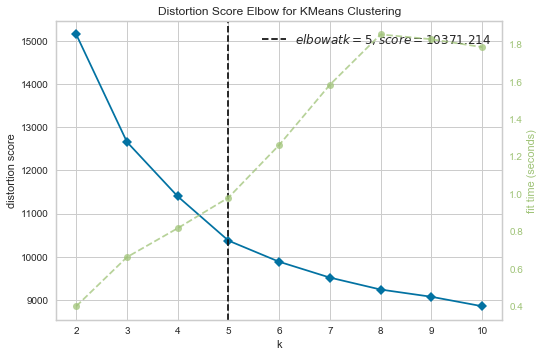

In [387]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [388]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [389]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

4125

In [390]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [391]:
tweet_label_df.head()

,cleanData,cluster_label
0,if you are a minor you need to stay out of ns...,4
1,long,4
2,i am just so tired [url],2
3,do it,4
4,reminder about this because this isn t fucking...,4


In [392]:
tweet_label_df.cluster_label.value_counts()

4    2153
2     800
3     600
1     407
0     165
Name: cluster_label, dtype: int64

In [393]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_11, tweet_label_df, on='cleanData')

In [394]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,mars ðŸŽƒðŸ�‚,"oh god, it's raining but i'm not complaining.",4,22 . they/them,depressed_user_15,0.0,9/2/2020 0:05,"if you are a minor, you need to stay out of ns...",deltasmachine,1.0,2,2020-09-02 00:05,11,"if you are a minor, you need to stay out of ns...",if you are a minor you need to stay out of ns...,11,4
1,mars ðŸŽƒðŸ�‚,"oh god, it's raining but i'm not complaining.",0,22 . they/them,depressed_user_15,0.0,9/2/2020 0:05,@ufopossum long,deltasmachine,1.0,2,2020-09-02 00:05,11,@ufopossum long,long,11,4
2,mars ðŸŽƒðŸ�‚,"oh god, it's raining but i'm not complaining.",1,22 . they/them,depressed_user_15,0.0,9/2/2020 0:07,i am just. so tired. https://t.co/9Jh3tzTGSr,deltasmachine,1.0,2,2020-09-02 00:07,11,i am just. so tired. [URL],i am just so tired [url],11,2
3,mars ðŸŽƒðŸ�‚,"oh god, it's raining but i'm not complaining.",1,22 . they/them,depressed_user_15,0.0,9/2/2020 0:09,@ufopossum DO IT,deltasmachine,1.0,2,2020-09-02 00:09,11,@ufopossum DO IT,do it,11,4
4,mars ðŸŽƒðŸ�‚,"oh god, it's raining but i'm not complaining.",0,22 . they/them,depressed_user_15,0.0,9/2/2020 0:10,reminder about this because this isn't fucking...,deltasmachine,1.0,2,2020-09-02 00:10,11,reminder about this because this isn't fucking...,reminder about this because this isn t fucking...,11,4


In [395]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [396]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [397]:
output_filename = "depTweets_window_11_kmeans_withLabel.csv"

In [398]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [399]:
depressed_dataset_with_labels.cluster_label.value_counts()

4    2426
2     800
3     606
1     411
0     165
Name: cluster_label, dtype: int64

In [400]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 12**

In [401]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_12_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 12

In [402]:
len(depressed_data_embedfile.keys())

2577

In [403]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [404]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [405]:
len(depressed_data_embed_flag.keys())

2577

In [406]:
len(depressed_dataset_12)

2729

In [407]:
depressed_dataset_12["encode_flag"] = depressed_dataset_12["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [408]:
depressed_dataset_12.encode_flag.value_counts()

12    2729
Name: encode_flag, dtype: int64

In [409]:
depressed_dataset_12.cleanData.nunique()

2577

**Clustering on Time window 12 dataset**

**Approach 1 - kMeans**

In [410]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [411]:
len(list(depressed_data_embedfile.values()))

2577

In [412]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

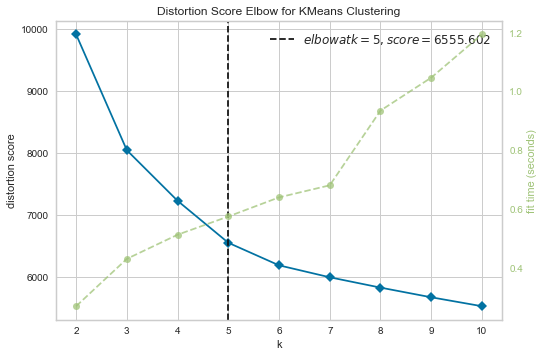

In [413]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [414]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [415]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

2577

In [416]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [417]:
tweet_label_df.head()

,cleanData,cluster_label
0,there no longer making kuwtk 2020 is official...,0
1,this was absolutely adorable,0
2,it gets to absurd levels when you have student...,2
3,good for you our marketing manager ...,3
4,worth noting that i even have prescription cov...,2


In [418]:
tweet_label_df.cluster_label.value_counts()

0    1369
2     516
3     322
4     283
1      87
Name: cluster_label, dtype: int64

In [419]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_12, tweet_label_df, on='cleanData')

In [420]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,AlexaJade ð???ð??»ð??»â??ï¸�,creative lifestyle blogger ð??» Disney lover ð...,0,"Southampton, England",depressed_user_4,0.0,9/9/2020 0:00,There no longer making KUWTK! 2020 is official...,AlexaJadeBlog,1.0,2,2020-09-09 00:00,12,There no longer making KUWTK! 2020 is official...,there no longer making kuwtk 2020 is official...,12,0
1,Kaia â˜€ï¸�,Black Lives Matter,0,I travel too much for this,depressed_user_39,0.0,9/9/2020 0:03,@BASED_GOSH This was absolutely adorable,KaiaVictoria,1.0,2,2020-09-09 00:03,12,@BASED_GOSH This was absolutely adorable,this was absolutely adorable,12,0
2,Zero (they/their),Autistic. ADHD. NB. \r\r\r\nExtra. Compulsivel...,0,,depressed_user_100,0.0,9/9/2020 0:04,@vrich219 It gets to absurd levels when you ha...,ZeroWrites,1.0,2,2020-09-09 00:04,12,@vrich219 It gets to absurd levels when you ha...,it gets to absurd levels when you have student...,12,2
3,ð??? I Canâ??t Keep Quiet - Anymore,Unapologetically me. There are times when â??f...,1,"NoneYa! ð?¤� PNW, USA",depressed_user_54,0.0,9/9/2020 0:06,@BryanBox7 @libbybakalar Good for you! Our â??...,MichelleECalvin,1.0,2,2020-09-09 00:06,12,@BryanBox7 @libbybakalar Good for you! Our â??...,good for you our marketing manager ...,12,3
4,ipickuppennies,"Disability, frugality and other life adventure...",1,"Phoenix, AZ",depressed_user_32,0.0,9/9/2020 0:06,@JasonVitug Worth noting that I even have pres...,ipickuppennies,1.0,2,2020-09-09 00:06,12,@JasonVitug Worth noting that I even have pres...,worth noting that i even have prescription cov...,12,2


In [421]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [422]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [423]:
output_filename = "depTweets_window_12_kmeans_withLabel.csv"

In [424]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [425]:
depressed_dataset_with_labels.cluster_label.value_counts()

0    1520
2     517
3     322
4     283
1      87
Name: cluster_label, dtype: int64

In [426]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 13**

In [427]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_13_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 13

In [428]:
len(depressed_data_embedfile.keys())

1457

In [429]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [430]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [431]:
len(depressed_data_embed_flag.keys())

1457

In [432]:
len(depressed_dataset_13)

2729

In [433]:
depressed_dataset_13["encode_flag"] = depressed_dataset_13["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [434]:
depressed_dataset_13.encode_flag.value_counts()

13    1569
Name: encode_flag, dtype: int64

In [435]:
depressed_dataset_13.cleanData.nunique()

1457

**Clustering on Time window 13 dataset**

**Approach 1 - kMeans**

In [436]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [437]:
len(list(depressed_data_embedfile.values()))

1457

In [438]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

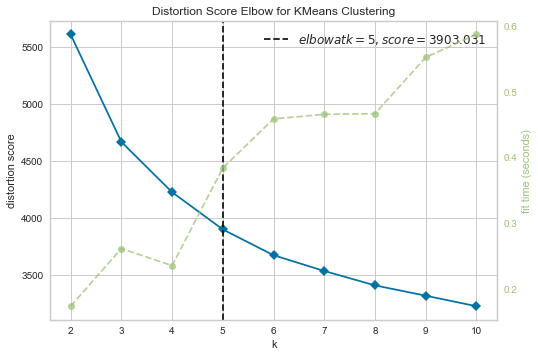

In [439]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [440]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [441]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

1457

In [442]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [443]:
tweet_label_df.head()

,cleanData,cluster_label
0,response of trying to argue my case in the lim...,0
1,agree there or muffins lol,1
2,yeah it can be harrowing but there s good s...,1
3,me not knowing chanhee and new are the same pe...,4
4,yes,1


In [444]:
tweet_label_df.cluster_label.value_counts()

1    755
0    257
4    221
2    157
3     67
Name: cluster_label, dtype: int64

In [445]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_13, tweet_label_df, on='cleanData')

In [446]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,Dr. J-Cat...5150ðŸ’€ðŸŒ¹,An open mind. Aspiring for greater knowledge f...,0,your mindðŸ¤”,depressed_user_36,0.0,9/16/2020 0:00,@ByronsShade Response of trying to argue my ca...,jcat_5150,1.0,2,2020-09-16 00:00,13,@ByronsShade Response of trying to argue my ca...,response of trying to argue my case in the lim...,13,0
1,â?¨ â?¢Â·Ì«â?¢ prÎ¹nceÑ?Ñ? peacÐ½ Ï?Ï?Ï? ð??¿,25. Cannabis Microbiologist . Casual Streamer....,0,"New York, USA",depressed_user_46,0.0,9/16/2020 0:00,"@thehood1983 Agree there , or muffins lol",lextaliones_,1.0,2,2020-09-16 00:00,13,"@thehood1983 Agree there , or muffins lol",agree there or muffins lol,13,1
2,ipickuppennies,"Disability, frugality and other life adventure...",4,"Phoenix, AZ",depressed_user_32,0.0,9/16/2020 0:03,@Jovermyer1 Yeah it can be harrowing. But ther...,ipickuppennies,1.0,2,2020-09-16 00:03,13,@Jovermyer1 Yeah it can be harrowing. But ther...,yeah it can be harrowing but there s good s...,13,1
3,tyler,professional sungchan bark enjoyer,0,he/him 20,depressed_user_3,0.0,9/16/2020 0:03,me not knowing Chanhee and New are the same pe...,420limitless,1.0,2,2020-09-16 00:03,13,me not knowing Chanhee and New are the same pe...,me not knowing chanhee and new are the same pe...,13,4
4,Dr. J-Cat...5150ðŸ’€ðŸŒ¹,An open mind. Aspiring for greater knowledge f...,0,your mindðŸ¤”,depressed_user_36,0.0,9/16/2020 0:05,@educated_educ8r Yes...,jcat_5150,1.0,2,2020-09-16 00:05,13,@educated_educ8r Yes...,yes,13,1


In [447]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [448]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [449]:
output_filename = "depTweets_window_13_kmeans_withLabel.csv"

In [450]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [451]:
depressed_dataset_with_labels.cluster_label.value_counts()

1    866
0    257
4    221
2    158
3     67
Name: cluster_label, dtype: int64

In [452]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings

**To check if all tweets are embedded and their corresponding embeddings are available - Time Window 14**

In [453]:


depressed_data_embedfile = open("D:\Workspace\OVGU\SM_Depression\scripts\embeddings_sentences\depressed_dataset_14_embedding.pkl","rb")

depressed_data_embedfile = pickle.load(depressed_data_embedfile)

embed_value = 14

In [454]:
len(depressed_data_embedfile.keys())

833

In [455]:
depressed_data_embedfile = OrderedDict(depressed_data_embedfile)

In [456]:
depressed_data_embed_flag = {key:int(embed_value) for key, value in depressed_data_embedfile.items()}

In [457]:
len(depressed_data_embed_flag.keys())

833

In [458]:
len(depressed_dataset_14)

887

In [459]:
depressed_dataset_14["encode_flag"] = depressed_dataset_14["cleanData"].apply(lambda x: depressed_data_embed_flag.get(x))


D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [460]:
depressed_dataset_14.encode_flag.value_counts()

14    887
Name: encode_flag, dtype: int64

In [461]:
depressed_dataset_14.cleanData.nunique()

833

**Clustering on Time window 14 dataset**

**Approach 1 - kMeans**

In [462]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [463]:
len(list(depressed_data_embedfile.values()))

833

In [464]:
depressed_embeddings = np.array(list(depressed_data_embedfile.values()))

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Softwares\Anaconda\lib\site

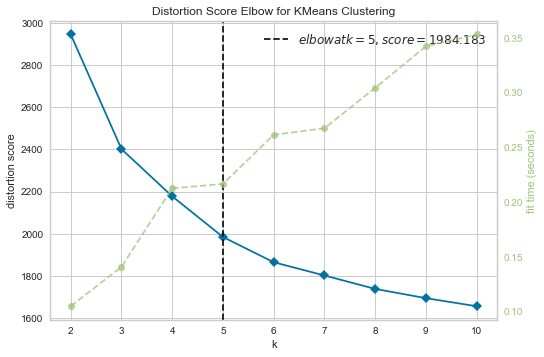

In [465]:
model = KMeans(init='k-means++', n_jobs=4)
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(depressed_embeddings)    
visualizer.show()  

In [466]:
kmeans = KMeans(n_clusters=5,init='k-means++', n_jobs=4)
kmeans = kmeans.fit(depressed_embeddings)

D:\Softwares\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [467]:
kmeans_labels = kmeans.labels_

len(kmeans_labels)

833

In [468]:
tweet_label_df = pd.DataFrame()
tweet_label_df['cleanData'] = depressed_data_embedfile.keys()
tweet_label_df['cluster_label'] = kmeans_labels

In [469]:
tweet_label_df.head()

,cleanData,cluster_label
0,i think i m gonna get it then i suspect it s...,3
1,but there are fine people on both sides ...,3
2,what if the mog is out of town,4
3,tbh i don t even think you re that much of an ...,1
4,you re a literal child you shouldn t be invol...,1


In [470]:
tweet_label_df.cluster_label.value_counts()

1    460
3    161
4    146
0     50
2     16
Name: cluster_label, dtype: int64

In [471]:
depressed_dataset_with_labels = pd.merge(depressed_dataset_14, tweet_label_df, on='cleanData')

In [472]:
depressed_dataset_with_labels.head()

,accountname,description,favorite_count,location,masked_user_id,retweet_count,timestamp,tweets,twittername,user_type,format,new_date,time_window,tweets_url_token,cleanData,encode_flag,cluster_label
0,"Jason Custer, PhD",Rhet/Comp PhD from @fsu_englishdept // Academi...,1,Here and There Along the Echo,depressed_user_35,0.0,9/23/2020 0:04,"@FeelTheBryn I think I'm gonna get it, then! I...",JasonCusterPhD,1.0,2,2020-09-23 00:04,14,"@FeelTheBryn I think I'm gonna get it, then! I...",i think i m gonna get it then i suspect it s...,14,3
1,ipickuppennies,"Disability, frugality and other life adventure...",3,"Phoenix, AZ",depressed_user_32,0.0,9/23/2020 0:09,@Done_by_Forty But there are fine people on bo...,ipickuppennies,1.0,2,2020-09-23 00:09,14,@Done_by_Forty But there are fine people on bo...,but there are fine people on both sides ...,14,3
2,Dr. J-Cat...5150ðŸ’€ðŸŒ¹,An open mind. Aspiring for greater knowledge f...,1,your mindðŸ¤”,depressed_user_36,0.0,9/23/2020 0:25,@AwsumPreacher What if the MOG is out of town?,jcat_5150,1.0,2,2020-09-23 00:25,14,@AwsumPreacher What if the MOG is out of town?,what if the mog is out of town,14,4
3,THANA says BLACK LIVES MATTER,??NSFW WARNING??\r\r\r\n20/She/They/Pan/Poly |...,0,Hazmat's lap,depressed_user_25,0.0,9/23/2020 0:31,@CoyoteLovelyYT Tbh I don't even think you're ...,GAMMAHECKER,1.0,2,2020-09-23 00:31,14,@CoyoteLovelyYT Tbh I don't even think you're ...,tbh i don t even think you re that much of an ...,14,1
4,THANA says BLACK LIVES MATTER,??NSFW WARNING??\r\r\r\n20/She/They/Pan/Poly |...,1,Hazmat's lap,depressed_user_25,0.0,9/23/2020 0:35,@_jellybeany_ @CoyoteLovelyYT You're a literal...,GAMMAHECKER,1.0,2,2020-09-23 00:35,14,@_jellybeany_ @CoyoteLovelyYT You're a literal...,you re a literal child you shouldn t be invol...,14,1


In [473]:
depressed_dataset_with_labels.columns

Index(['accountname', 'description', 'favorite_count', 'location',
       'masked_user_id', 'retweet_count', 'timestamp', 'tweets', 'twittername',
       'user_type', 'format', 'new_date', 'time_window', 'tweets_url_token',
       'cleanData', 'encode_flag', 'cluster_label'],
      dtype='object')

In [474]:
writeColumns = ['masked_user_id','new_date', 'time_window','cleanData','cluster_label']

In [475]:
output_filename = "depTweets_window_14_kmeans_withLabel.csv"

In [476]:
depressed_dataset_with_labels.to_csv(os.path.join(r"D:\Workspace\OVGU\SM_Depression\src\time_window\kmeans_cluster", output_filename),encoding="utf-8",columns = writeColumns,index=False, date_format='%Y-%m-%d %H:%M')

In [477]:
depressed_dataset_with_labels.cluster_label.value_counts()

1    514
3    161
4    146
0     50
2     16
Name: cluster_label, dtype: int64

In [478]:
del depressed_data_embed_flag,depressed_data_embedfile,depressed_dataset_with_labels,depressed_embeddings